In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
n_experiments = 8
SUFFIX = 'latent28'


#TESTING ######
EPOCHS = 2
filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
n_experiments = 2
SUFFIX = 'latent28'
###########

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.22/08


2022-06-02 16:36:22.262819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 16:36:22.262859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
PI = experiment.Experimenter(filename)

Initializing Experimenter
	Loading Data from ../data/data50k_raw_combined_atlas_cut_small.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing


In [6]:
PI.fromSaved(suffix=SUFFIX)

Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data50k_raw_combined_atlas_cut_smalllatent28
Experimenter Loaded
Getting split
Split Stored
Loading models
{'latent_two_5_(64, 128, 256, 128, 2)_64': 'models/data50k_raw_combined_atlas_cut_small_latent_two_5_(64, 128, 256, 128, 2)_64latent28', 'latent_eight_5_(64, 128, 256, 128, 8)_64': 'models/data50k_raw_combined_atlas_cut_small_latent_eight_5_(64, 128, 256, 128, 8)_64latent28'}
Loaded latent_two_5_(64, 128, 256, 128, 2)_64 from models/data50k_raw_combined_atlas_cut_small_latent_two_5_(64, 128, 256, 128, 2)_64latent28
Loaded latent_eight_5_(64, 128, 256, 128, 8)_64 from models/data50k_raw_combined_atlas_cut_small_latent_eight_5_(64, 128, 256, 128, 8)_64latent28


In [9]:
PI.models

{'latent_two_5_(64, 128, 256, 128, 2)_64': <Architectures.Pairwise at 0x7ffb66959e50>,
 'latent_eight_5_(64, 128, 256, 128, 8)_64': <Architectures.Pairwise at 0x7ffb66980220>}

In [10]:
latent2 = PI.models['latent_two_5_(64, 128, 256, 128, 2)_64']
latent8 = PI.models['latent_eight_5_(64, 128, 256, 128, 8)_64']

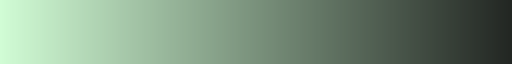

In [100]:
sns.dark_palette("#d1fcd5", reverse=True, as_cmap=True)

In [136]:
import seaborn as sns

from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def earth_movers_distance(x,y,N=1300):
    d = cdist(x[:N],y[:N])
    assignment = linear_sum_assignment(d)
    return (d[assignment].sum()/N)

import math
def rotate(p, origin=(0, 0), angle=0):
    #ANGLE IN RADS
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    p = p - o
    p = [R@pnt for pnt in p]
    
    return p + o


def gen_tsne(curr_event, latent_label, text=r'\textbf{Latent Representation} in Pairwise Architecture', rotated=True):
    c_cut = 5
    cmap = sns.cubehelix_palette(start=26/10, light=.97, as_cmap=True)

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 16
    plt.rcParams['figure.autolayout'] = False
    plt.rcParams['text.usetex'] = True

    ttH_loc = np.array([curr_event[i] for i in range(len(latent_label)) if latent_label[i][1]==1])
    nttH_loc = np.array([curr_event[i] for i in range(len(latent_label)) if latent_label[i][0]==1])

    if(rotated):
        cntr      = np.array([np.mean(curr_event[:,0]), np.mean(curr_event[:, 1])])
        ttH_cntr  = np.array([np.mean(ttH_loc[:,0]), np.mean(ttH_loc[:, 1])])
        nttH_cntr = np.array([np.mean(nttH_loc[:,0]), np.mean(nttH_loc[:, 1])])
        tmp = ttH_cntr - cntr
        tmp = tmp / np.linalg.norm(tmp)
        angl = -np.arctan(tmp[1]/tmp[0])
        print(ttH_loc[0])
        ttH_loc = rotate(ttH_loc, origin=cntr, angle=angl)
        print(ttH_loc[0])
        nttH_loc = rotate(nttH_loc, origin=cntr, angle=angl)
    
    
    emd = earth_movers_distance(ttH_loc, nttH_loc)
    print('earth mover’s distance', emd)
       
    g = sns.jointplot(x=ttH_loc[:,0], y = ttH_loc[:,1], color=cmap(100), space=0, label='ttH jets',
                      cmap=cmap, kind='kde', height=10, fill=True, cut=c_cut,
                     marginal_kws={'linewidth': 0.0, 'alpha':1.0})

    linew = 1
    bgrey = sns.dark_palette('#d495f4', reverse=True, as_cmap=True)
    COL2 = bgrey(.8)
    sns.kdeplot(x=nttH_loc[:,0], y = nttH_loc[:,1], shade=False, label=r'ttbar jets',cmap=bgrey, linewidths=linew, cut=c_cut, 
                levels=10, ax=g.ax_joint)

    sns.kdeplot(nttH_loc[:,0], ax=g.ax_marg_x, color=COL2, lw=linew)
    sns.kdeplot(y=nttH_loc[:,1], ax=g.ax_marg_y, color=COL2, lw=linew)

    ax = g.ax_joint

    import matplotlib.patches as  mpatches
    import matplotlib.lines as  mlines
    
    handles = [mpatches.Patch(facecolor=cmap(100), label=r'$tt(H\rightarrow\tau\tau)$ Events'),
               mlines.Line2D([], [], color=COL2, label=r'$t\overline{t}$ Events', lw=linew)]
    legend = ax.legend(loc='upper left', handles=handles, frameon=False, title=text)
    legend._legend_box.align = 'left'

    plt.setp(legend.get_texts(), color=cmap(0.98))
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 16
    plt.rcParams['figure.autolayout'] = True



    ax.set_facecolor(cmap(c_cut))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    g.ax_marg_y.get_yaxis().set_visible(False)
    g.ax_marg_x.get_xaxis().set_visible(False)
    

    ax.text(.98, .02,
            s=r"{Earth Mover's Distance:} $\mathbf{%.3f}$"%emd, 
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',)
    
    return g

import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']




In [13]:
X_test, y_test = PI.get_test_dataset('latent_two')

In [14]:
n_cut = int(len(X_test)*0.5)
indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]
latent_label = y_test.numpy()[cut]

In [15]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
def compute_tsne_embedded(latent_reps, perplexity=50):
    distance_matrix = pairwise_distances(latent_reps, latent_reps, metric='cosine', n_jobs=-1)
    latent_reps_embedded_tsne = TSNE(metric="precomputed", n_components=2, learning_rate='auto', 
                                      verbose=2, perplexity=perplexity, 
                                     n_iter=2000, n_jobs=-1)
    latent_reps_embedded = latent_reps_embedded_tsne.fit_transform(distance_matrix)
    return latent_reps_embedded

def compute_tsne(model, perplexity=50):
    latent_getter = LatentGetter(model.layers[0:3], condensed=True)
    latent_reps = latent_getter.predict(X_test.numpy()[cut])
    return compute_tsne_embedded(latent_reps, perplexity=perplexity)

In [16]:
latent8_embedded = compute_tsne(latent8)

[t-SNE] Computing 149 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.001s...
[t-SNE] Computed neighbors for 150 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.010588
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 44.6125793, gradient norm = 0.8230121 (50 iterations in 1.188s)
[t-SNE] Iteration 100: error = 44.6472130, gradient norm = 0.8567443 (50 iterations in 1.012s)
[t-SNE] Iteration 150: error = 44.2199516, gradient norm = 0.8484801 (50 iterations in 1.229s)
[t-SNE] Iteration 200: error = 45.3186531, gradient norm = 0.7856947 (50 iterations in 0.701s)
[t-SNE] Iteration 250: error = 45.2219200, gradient norm = 0.8135828 (50 iterations in 0.589s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.221920
[t-SNE] Iteration 300: error = 0.1984290, gradient norm = 0.0046332 (50 iterations in 0.036s)
[t-SNE] Iteration 350: error = 0.1779669, gradient norm = 0.0001570 

2022-06-02 16:38:18.473187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-02 16:38:18.474828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


[ 0.59304446 -0.24823833]
[-1.6343064   0.43860483]
earth mover’s distance 0.24590897926521604


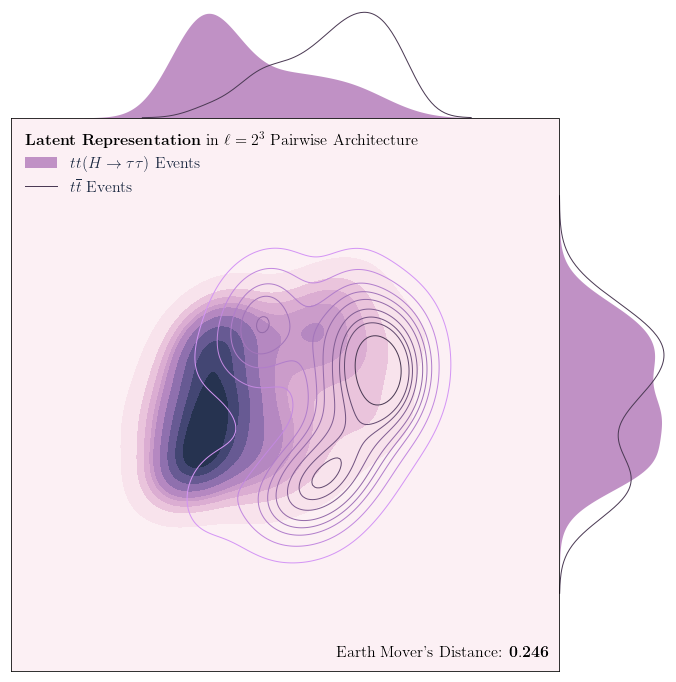

In [137]:
ax = gen_tsne(latent8_embedded, latent_label, text=r'\textbf{Latent Representation} in $\ell=2^3$ Pairwise Architecture')

In [27]:
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PI.events_test, PI.events_oup_test, PI.events_tag_test)

In [28]:
ATLAS_embedded = compute_tsne_embedded(np.array(X_test_ATLAS)[cut])

[t-SNE] Computing 149 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.003s...
[t-SNE] Computed neighbors for 150 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.006518
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 44.5765343, gradient norm = 0.8811092 (50 iterations in 0.092s)
[t-SNE] Iteration 100: error = 45.0706825, gradient norm = 0.8484738 (50 iterations in 0.036s)
[t-SNE] Iteration 150: error = 46.1318932, gradient norm = 0.8030984 (50 iterations in 0.038s)
[t-SNE] Iteration 200: error = 43.8105850, gradient norm = 0.9173244 (50 iterations in 0.513s)
[t-SNE] Iteration 250: error = 44.9353943, gradient norm = 0.8761006 (50 iterations in 1.213s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.935394
[t-SNE] Iteration 300: error = 0.3073460, gradient norm = 0.0022141 (50 iterations in 1.220s)
[t-SNE] Iteration 350: error = 0.2604858, gradient norm = 0.0019705 

[1.5745991 4.2557693]
[1.8352078 4.6539516]
earth mover’s distance 0.24343305752788197


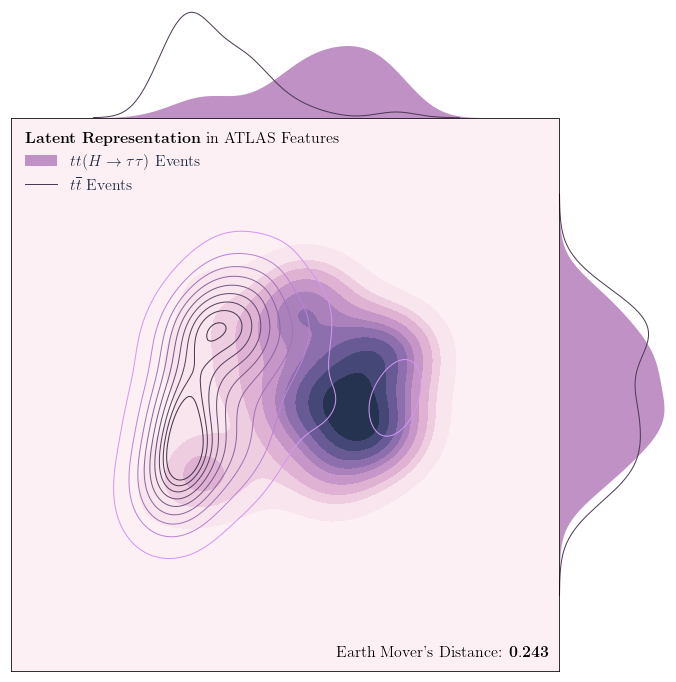

In [138]:
ax = gen_tsne(ATLAS_embedded, latent_label, text=r'\textbf{Latent Representation} in ATLAS Features')


In [141]:
from scipy.stats import wasserstein_distance

np.random.seed(0)
n = 30000

Y1 = np.random.randn(n)
Y2 = np.random.randn(n)-3

for N in np.arange(1000, 2000, 100):
    print(N, earth_movers_distance(np.reshape(Y1, (n, 1)), np.reshape(np.atleast_2d(Y2), (n,1)), N=N), wasserstein_distance(Y1, Y2))

# assignment = linear_sum_assignment(d)
# print(d[assignment].sum() / n)       # 1.9777950447866477
# print(wasserstein_distance(Y1, Y2))  # 1.977795044786648

1000 2.969954282714013 2.9958392271818117
1100 2.955895146644134 2.9958392271818117
1200 2.972357356364931 2.9958392271818117
1300 2.9847365038915767 2.9958392271818117
1400 2.9908280502469142 2.9958392271818117
1500 2.9860224842588727 2.9958392271818117
1600 2.983890513416228 2.9958392271818117
1700 2.990946308172115 2.9958392271818117
1800 2.9887428172839505 2.9958392271818117
1900 2.9814057607257918 2.9958392271818117


In [41]:
from scipy.stats import wasserstein_distance

np.random.seed(0)
n = 100

Y1 = np.random.randn(n)
Y2 = np.random.randn(n) - 2
d =  np.abs(Y1 - Y2.reshape((n, 1)))

assignment = linear_sum_assignment(d)
print(d[assignment].sum() / n)       # 1.9777950447866477
print(wasserstein_distance(Y1, Y2))  # 1.977795044786648

1.9777950447866477
1.977795044786648


In [ ]:
print(earth_movers_distance(np.atleast_2d(Y1), np.atleast_2d(Y2), N=n), wasserstein_distance(Y1, Y2))

[0.99640524 4.9185696 ] [2.5340748 1.881577 ]
KL div 1.1948242701211509


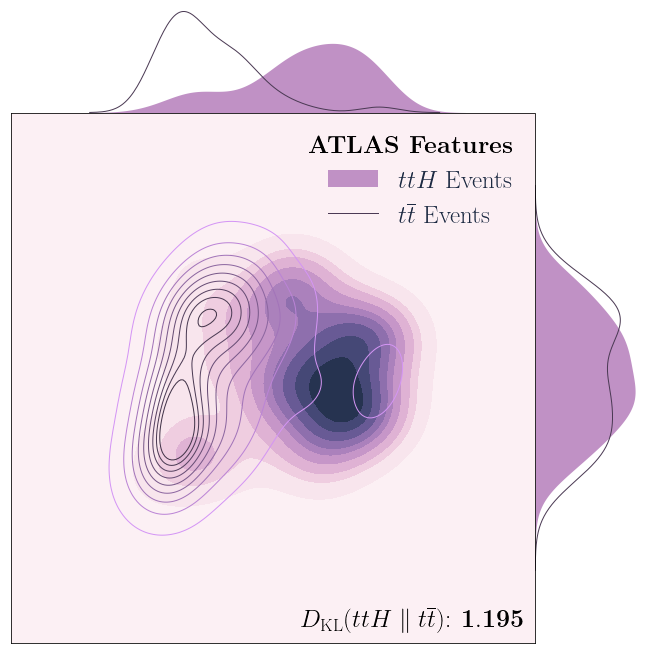

In [170]:
from utils import *

axATLAS = gen_tsne(ATLAS_embedded, latent_label, text=r'\textbf{ATLAS Features}')
axATLAS.savefig('figures/ATLAS_tsne.pdf')